# fct_monthly_schedule_route_direction_summary
* schedule stats (headway, freq, n_trips) by route-direction
* operator summary charts
* [Tiffany's explanation](https://github.com/cal-itp/data-analyses/issues/1752#issuecomment-3563818122)

In [1]:
import datetime
import sys

import google.auth
import pandas as pd
from google.cloud import bigquery
from loguru import logger
from shared_utils import rt_dates
from update_vars import SEGMENT_GCS

credentials, project = google.auth.default()

import _operator_grain_route_dir_visuals as _report_operator_visuals
from IPython.display import HTML, Image, Markdown, display, display_html
from omegaconf import OmegaConf
from shared_utils import gtfs_utils_v2, portfolio_utils, publish_utils
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS

readable_dict = OmegaConf.load("readable2.yml")

import altair as alt

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# rt_dates.DATES

In [4]:
aug_2025 = "2025-08-20"

In [5]:
analysis_name = "City and County of San Francisco"

In [6]:
def formatted(number):
    return "{:,}".format(number)

## Edit SQL query so I only load the most recent date.

In [7]:
sql_query = f"""
        SELECT 
        name,
        route_name,
        direction_id, 
        frequency_all_day,
        frequency_offpeak,
        frequency_peak,
        daily_service_hours,
        daily_trips_peak,
        daily_trips_offpeak,
        daily_trips_all_day,
        month_first_day
        FROM  `cal-itp-data-infra-staging.tiffany_mart_gtfs_rollup.fct_monthly_schedule_route_direction_summary`
        WHERE day_type = 'Weekday'
    """

In [8]:
client = bigquery.Client()

query_job = client.query(sql_query)

fct_monthly_schedule_df = query_job.result().to_dataframe()

In [9]:
fct_monthly_schedule_df.sample().T

,10018
name,Flixbus Schedule
route_name,2184__FlixBus 2184 Portland - Boise
direction_id,0
frequency_all_day,0.33
frequency_offpeak,NaN
frequency_peak,NaN
daily_service_hours,3.83
daily_trips_peak,NaN
daily_trips_offpeak,NaN
daily_trips_all_day,1.00


In [10]:
fct_monthly_schedule_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71363 entries, 0 to 71362
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 71363 non-null  object 
 1   route_name           71363 non-null  object 
 2   direction_id         68118 non-null  Int64  
 3   frequency_all_day    71363 non-null  float64
 4   frequency_offpeak    4889 non-null   float64
 5   frequency_peak       48616 non-null  float64
 6   daily_service_hours  71306 non-null  float64
 7   daily_trips_peak     48616 non-null  float64
 8   daily_trips_offpeak  48616 non-null  float64
 9   daily_trips_all_day  71363 non-null  float64
 10  month_first_day      71363 non-null  dbdate 
dtypes: Int64(1), dbdate(1), float64(7), object(2)
memory usage: 6.1+ MB


In [11]:
fct_monthly_schedule_df.daily_service_hours.describe()

count    71306.00
mean        31.48
std        738.47
min          0.07
25%          3.72
50%          9.90
75%         23.52
max     113956.93
Name: daily_service_hours, dtype: float64

In [12]:
fct_monthly_schedule_df = fct_monthly_schedule_df.pipe(
    portfolio_utils.standardize_portfolio_organization_names
)

In [13]:
# fct_monthly_schedule_df.analysis_name.unique()

In [14]:
subset_df = fct_monthly_schedule_df.loc[
    fct_monthly_schedule_df.analysis_name.isin([analysis_name])
]

In [15]:
subset_df.shape

(1409, 13)

In [16]:
subset_df.head(2)

,name,route_name,direction_id,frequency_all_day,frequency_offpeak,frequency_peak,daily_service_hours,daily_trips_peak,daily_trips_offpeak,daily_trips_all_day,month_first_day,analysis_name,source_record_id
6923,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,2025-03-01,City and County of San Francisco,recHD22phgJs34JHP
6924,Bay Area 511 Muni Schedule,FBUS__FBUS MARKET & WHARVES BUS,0,0.25,NaN,NaN,0.53,NaN,NaN,1.00,2025-04-01,City and County of San Francisco,recHD22phgJs34JHP


### Lightly clean dataframe

In [17]:
subset_df.columns = subset_df.columns.str.replace("_", " ").str.title()

In [20]:
subset_df["Month First Day"] = pd.to_datetime(subset_df["Month First Day"]).dt.strftime(
    "%B %Y"
)

/tmp/ipykernel_2191/932933499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Month First Day'] = pd.to_datetime(subset_df['Month First Day']).dt.strftime('%B %Y')


In [21]:
subset_df = subset_df.rename(
    columns={
        "Direction Id": "Direction",
        "Month First Day": "Date",
        "Route Name": "Route",
    }
)

In [22]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 6923 to 71195
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 1409 non-null   object 
 1   Route                1409 non-null   object 
 2   Direction            1409 non-null   Int64  
 3   Frequency All Day    1409 non-null   float64
 4   Frequency Offpeak    428 non-null    float64
 5   Frequency Peak       1114 non-null   float64
 6   Daily Service Hours  1409 non-null   float64
 7   Daily Trips Peak     1114 non-null   float64
 8   Daily Trips Offpeak  1114 non-null   float64
 9   Daily Trips All Day  1409 non-null   float64
 10  Date                 1409 non-null   object 
 11  Analysis Name        1409 non-null   object 
 12  Source Record Id     1409 non-null   object 
dtypes: Int64(1), float64(7), object(5)
memory usage: 155.5+ KB


### Average Scheduled Minutes
* Use `daily_service_hours`
* Replace `avg_scheduled_min_chart` in `_report_operator_visuals`
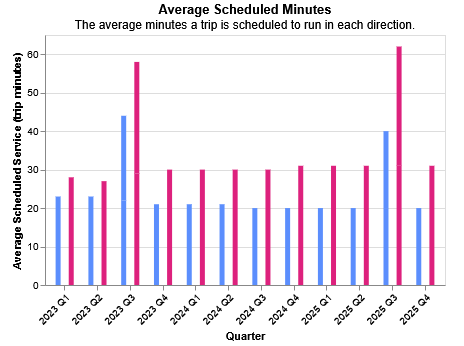

In [23]:
routes_list = subset_df["Route"].unique().tolist()

In [25]:
route_dropdown = alt.binding_select(
    options=routes_list,
    name="Routes: ",
)

# Column that controls the bar charts
xcol_param = alt.selection_point(
    fields=["Route"], value=routes_list[0], bind=route_dropdown
)

In [26]:
avg_scheduled_min_tooltip = ["Date", "Route", "Direction", "Daily Service Hours"]

In [31]:
avg_scheduled_min_dict = readable_dict.avg_scheduled_min_graph

In [32]:
avg_scheduled_min_chart = (
    _report_operator_visuals.grouped_bar_chart(
        subset_df,
        x_col="Date",
        y_col="Daily Service Hours",
        color_col="Direction:N",
        color_scheme=[*avg_scheduled_min_dict.colors],
        tooltip_cols=avg_scheduled_min_tooltip,
        date_format="",
        offset_col="Direction:N",
    )
    .add_params(xcol_param)
    .transform_filter(xcol_param)
)

In [33]:
_report_operator_visuals.configure_chart(
    avg_scheduled_min_chart,
    width=400,
    height=250,
    title=avg_scheduled_min_dict.title,
    subtitle=avg_scheduled_min_dict.subtitle,
)

alt.Chart(...)

### Total Scheduled Trips for Vehicles going Direction X
* Use `daily_trips_all_day`

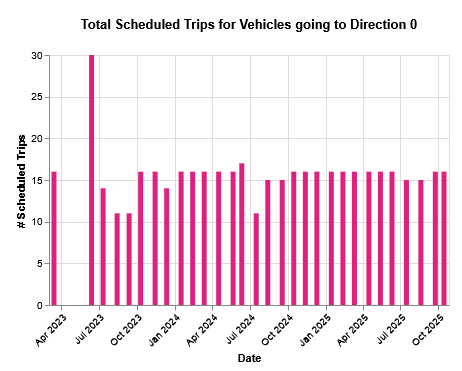

In [35]:
n_scheduled_dict = readable_dict.n_scheduled_graph

In [51]:
n_scheduled_tooltip = [
    "Date",
    "Route",
    "Direction",
    "Daily Trips All Day",
]

In [59]:
subset_df[["Daily Trips All Day", "Date", "Direction"]].head()

,Daily Trips All Day,Date,Direction
6923,1.00,March 2025,0
6924,1.00,April 2025,0
6925,1.00,October 2025,0
6926,1.00,July 2025,0
6927,1.00,August 2025,0


In [58]:
_report_operator_visuals.grouped_bar_chart(
    subset_df,
    x_col="Date",
    y_col="Daily Trips All Day",
    color_col="Direction:N",
    color_scheme=[*n_scheduled_dict.colors],
    tooltip_cols=n_scheduled_tooltip,
    date_format="",
    offset_col="Direction:N",
).add_params(xcol_param).transform_filter(xcol_param)

alt.Chart(...)

### Frequency of Trips Peak/Off Peak for Direction X
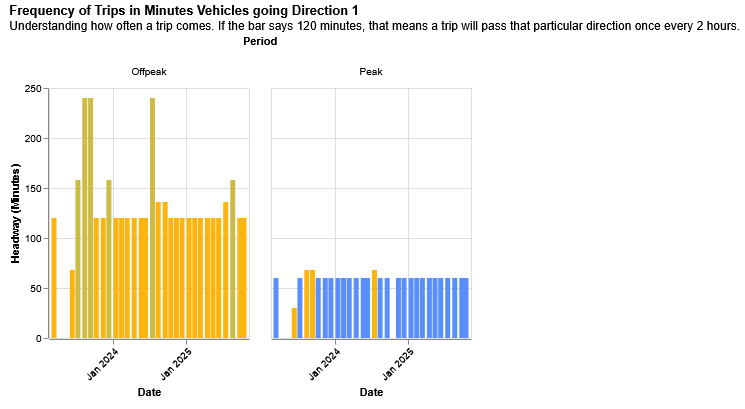

In [68]:
frequency_dict = readable_dict.avg_scheduled_min_graph

In [74]:
frequency_tooltip =  ["Date","Route","Direction","Period", "Headway (Minutes)",]

In [79]:
frequency_subset = subset_df[
    ["Route", "Direction", "Frequency Offpeak", "Frequency Peak", "Date"]
].melt(
    id_vars=["Date","Route", "Direction"], value_vars=["Frequency Offpeak", "Frequency Peak"]
)

In [80]:
frequency_subset.value = 60 / frequency_subset.value

In [81]:
frequency_subset = frequency_subset.rename(
    columns={"variable": "Period", "value": "Headway (Minutes)"}
)

In [83]:
frequency_subset.drop_duplicates().shape

(2818, 5)

In [84]:
frequency_subset.shape

(2818, 5)

In [85]:
_report_operator_visuals.bar_chart(
        x_col="Date",
        y_col="Headway (Minutes)",
        color_col="Headway (Minutes):N",
        color_scheme=frequency_dict,
        tooltip_cols=frequency_tooltip,
        date_format="",
    )

ValueError: Date encoding field is specified without a type; the type cannot be automatically inferred because the data is not specified as a pandas.DataFrame.

alt.Chart(...)

In [82]:
_report_operator_visuals.grouped_bar_chart(
    frequency_subset.loc[frequency_subset.Direction == 0],
    x_col="Date",
    y_col="Headway (Minutes)",
    color_col="Direction:N",
    color_scheme=[*frequency_dict.colors],
    tooltip_cols=frequency_tooltip,
    date_format="",
    offset_col="Peak/Offpeak:N",
).add_params(xcol_param).transform_filter(xcol_param)

alt.Chart(...)